In [1]:
import requests
import pandas as pd

url = "https://api.coingecko.com/api/v3/coins/markets"

params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 50,   # pull more so filtering still leaves ~20
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
data = response.json()

df = pd.DataFrame(data)[
    ["market_cap_rank", "symbol", "name", "market_cap", "current_price"]
]

# -----------------------------
# Filters
# -----------------------------

stablecoins = {
    "usdt", "usdc", "busd", "dai", "tusd",
    "usdp", "fdusd", "gusd", "lusd",
    "ust", "ustc", "usdd", "eurc",'usds','usde','bsc-usd','usd1'
}

# normalize text
df["symbol"] = df["symbol"].str.lower()
df["name"] = df["name"].str.lower()

# remove stablecoins
df = df[~df["symbol"].isin(stablecoins)]

# remove wrapped coins
df = df[
    ~df["name"].str.contains("wrapped") &
    ~df["symbol"].str.startswith("w")
]

# take top 20 after filtering
df = df.sort_values("market_cap", ascending=False).head(20)

print(df)


    market_cap_rank      symbol               name     market_cap  \
0                 1         btc            bitcoin  1648216294482   
1                 2         eth           ethereum   329355154575   
3                 4         bnb                bnb   114661240993   
4                 5         xrp                xrp   106822014638   
6                 7         sol             solana    65579863289   
7                 8         trx               tron    27446035661   
8                 9       steth  lido staked ether    26174158202   
9                10        doge           dogecoin    19298306996   
10               11  figr_heloc       figure heloc    15400549748   
11               12         ada            cardano    11930003216   
13               14         bch       bitcoin cash    10983844484   
20               21         leo          leo token     8485340089   
21               22         xmr             monero     7949044429   
22               23        link   

In [2]:
binance_symbols = requests.get(
    "https://api.binance.com/api/v3/exchangeInfo"
).json()

binance_assets = {
    s["baseAsset"].lower()
    for s in binance_symbols["symbols"]
    if s["quoteAsset"] == "USDT"
}

df = df[df["symbol"].isin(binance_assets)]


In [3]:
symbols = df["symbol"].str.upper().tolist()
print(symbols)


['BTC', 'ETH', 'BNB', 'XRP', 'SOL', 'TRX', 'DOGE', 'ADA', 'BCH', 'XMR', 'LINK', 'XLM', 'ZEC', 'LTC', 'SUI']


In [4]:
import time
import requests
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from statsmodels.tsa.stattools import coint

BASE_URL = "https://api.binance.com"
INTERVAL = "15m"
LIMIT = 1000


def fetch_klines_15m(symbol, lookback_days=30):
    """
    Fetch 15-minute klines with pagination.
    """
    ms_per_candle = 15 * 60 * 1000
    total_needed = lookback_days * 96
    end_time = int(pd.Timestamp.utcnow().timestamp() * 1000)

    data = []

    while len(data) < total_needed:
        params = {
            "symbol": symbol,
            "interval": INTERVAL,
            "limit": LIMIT,
            "endTime": end_time
        }

        r = requests.get(f"{BASE_URL}/api/v3/klines", params=params)
        r.raise_for_status()
        klines = r.json()

        if not klines:
            break

        data = klines + data
        end_time = klines[0][0] - 1

        time.sleep(0.12)

    df = pd.DataFrame(data, columns=[
        "open_time", "open", "high", "low", "close",
        "volume", "close_time", "qav", "trades",
        "tbbav", "tbqav", "ignore"
    ])

    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df.set_index("open_time", inplace=True)
    df = df.astype(float)

    return df["close"]


In [5]:
df

,market_cap_rank,symbol,name,market_cap,current_price
0,1,btc,bitcoin,1648216294482,82475.000000
1,2,eth,ethereum,329355154575,2727.820000
3,4,bnb,bnb,114661240993,840.920000
4,5,xrp,xrp,106822014638,1.750000
6,7,sol,solana,65579863289,115.770000
7,8,trx,tron,27446035661,0.289819
9,10,doge,dogecoin,19298306996,0.114461
11,12,ada,cardano,11930003216,0.324215
13,14,bch,bitcoin cash,10983844484,549.480000
21,22,xmr,monero,7949044429,430.880000


In [7]:
def build_price_matrix(symbols, lookback_days=30):
    prices = {}

    for sym in tqdm(symbols):
        pair = sym + "USDT"
        try:
            prices[sym] = fetch_klines_15m(pair, lookback_days)
        except Exception as e:
            print(f"[skip] {pair}: {e}")

    df = pd.DataFrame(prices)

    # Don't do df.dropna() here (too strict).
    # Keep NaNs; we handle them pairwise in the cointegration function.
    return df



In [8]:
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
from statsmodels.tsa.stattools import coint

def engle_granger_pairs(prices: pd.DataFrame, pval_threshold=0.05, min_obs=300):
    """
    Robust Engle–Granger scan:
    - aligns each pair only on their common timestamps
    - drops NaNs per pair
    - skips pairs with too few observations or near-constant series
    """
    results = []
    pairs = list(combinations(prices.columns, 2))

    for x, y in tqdm(pairs):
        # align only these two
        xy = pd.concat([prices[x], prices[y]], axis=1, join="inner").dropna()
        if xy.shape[0] < min_obs:
            continue

        sx = xy.iloc[:, 0].values
        sy = xy.iloc[:, 1].values

        # skip constant / near-constant series
        if np.nanstd(sx) < 1e-12 or np.nanstd(sy) < 1e-12:
            continue

        try:
            score, pvalue, _ = coint(sy, sx)  # test whether y and x are cointegrated
        except Exception:
            continue

        if np.isfinite(pvalue) and pvalue < pval_threshold:
            results.append({
                "pair": f"{x}-{y}",
                "x": x,
                "y": y,
                "pvalue": float(pvalue),
                "test_stat": float(score),
                "n_obs": int(xy.shape[0])
            })

    return pd.DataFrame(results).sort_values("pvalue")



In [9]:
prices_15m = build_price_matrix(symbols, lookback_days=30)

coint_pairs = engle_granger_pairs(
    prices_15m,
    pval_threshold=0.05,
    min_obs=300  # ~3 days of 15m bars; you can set 1000 for ~10 days
)

print(coint_pairs.head(20))


100%|██████████| 105/105 [00:12<00:00,  8.22it/s]

      pair    x    y    pvalue  test_stat  n_obs
1  ADA-XLM  ADA  XLM  0.001074  -4.534468   3000
0  XRP-XLM  XRP  XLM  0.007595  -3.982907   3000


In [27]:
import matplotlib.pyplot as plt

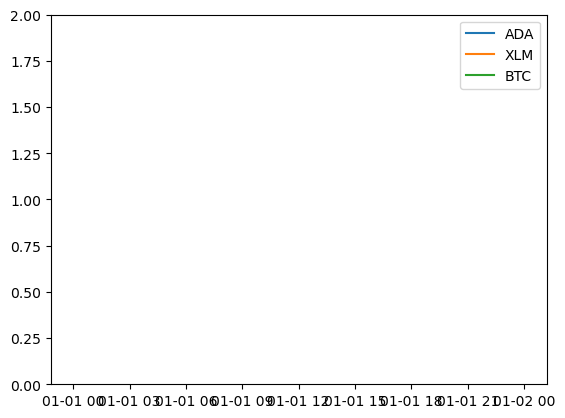

In [26]:
normalized_ada = prices_15m['ADA'] / prices_15m['ADA'].iloc[0]
normalized_xlm = prices_15m['XLM'] / prices_15m['XLM'].iloc[0]
normalized_btc = prices_15m['BTC'] / prices_15m['BTC'].iloc[0]
plt.plot(normalized_ada, label='ADA')
plt.plot(normalized_xlm, label='XLM')
plt.plot(normalized_btc, label='BTC')
plt.ylim(0,2)

plt.legend()
plt.show()

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def hedge_ratio(y: pd.Series, x: pd.Series) -> float:
    xy = pd.concat([y, x], axis=1).dropna()
    yv = xy.iloc[:, 0].values
    xv = sm.add_constant(xy.iloc[:, 1].values)
    model = sm.OLS(yv, xv).fit()
    return float(model.params[1])

def make_spread(prices: pd.DataFrame, y_sym: str, x_sym: str):
    y = prices[y_sym]
    x = prices[x_sym]
    beta = hedge_ratio(y, x)
    spread = (y - beta * x).dropna()
    return spread, beta



In [11]:
spread, beta = make_spread(prices_15m, y_sym="XLM", x_sym="ADA")
beta


0.48956575720311224

In [12]:
def fit_ou(spread: pd.Series, dt=1.0):
    """
    dt is 1 step = 1 bar (15m). Keep dt=1 for simplicity.
    Returns kappa, mu, sigma, half_life (in bars).
    """
    s = spread.dropna().values
    s_lag = s[:-1]
    s_next = s[1:]

    X = sm.add_constant(s_lag)
    model = sm.OLS(s_next, X).fit()
    a, b = model.params  # s_next = a + b*s_lag

    # Convert AR(1) -> OU
    if b <= 0 or b >= 1:
        # still return something, but OU interpretation becomes shaky
        kappa = np.nan
        mu = np.nan
        sigma = np.nan
        half_life = np.nan
        return kappa, mu, sigma, half_life, (a, b), model

    kappa = -np.log(b) / dt
    mu = a / (1 - b)

    # OU stationary sigma
    resid = model.resid
    var_eps = np.var(resid, ddof=1)
    sigma = np.sqrt(var_eps * 2 * kappa / (1 - b**2))

    half_life = np.log(2) / kappa  # in bars

    return float(kappa), float(mu), float(sigma), float(half_life), (float(a), float(b)), model


In [13]:
kappa, mu, sigma, half_life, (a,b), ou_reg = fit_ou(spread, dt=1.0)
kappa, mu, sigma, half_life


(0.01552208351358627,
 0.03513519770815122,
 0.0004642707696410138,
 44.65555026509443)

In [14]:
def ou_zscore(spread: pd.Series, kappa, mu, sigma):
    sigma_eq = sigma / np.sqrt(2 * kappa)
    z = (spread - mu) / sigma_eq
    return z, sigma_eq


In [15]:
def ou_pairs_strategy(prices: pd.DataFrame, y_sym: str, x_sym: str,
                      entry=2.0, exit=0.5, stop=4.0,
                      lookback_fit=2000):
    """
    Returns a dataframe with spread, z, positions on y and x.
    - Fit OU on the most recent lookback_fit bars.
    """
    spread, beta = make_spread(prices, y_sym=y_sym, x_sym=x_sym)

    # Fit OU on last lookback_fit bars (rolling-ish)
    train = spread.iloc[-lookback_fit:] if len(spread) > lookback_fit else spread
    kappa, mu, sigma, half_life, _, _ = fit_ou(train, dt=1.0)

    z, sigma_eq = ou_zscore(spread, kappa, mu, sigma)

    pos = 0  # +1 = long spread, -1 = short spread
    pos_series = []

    for zi in z:
        if pos == 0:
            if zi > entry:
                pos = -1   # short spread
            elif zi < -entry:
                pos = +1   # long spread
        else:
            # risk stop
            if abs(zi) > stop:
                pos = 0
            # mean reversion exit
            elif abs(zi) < exit:
                pos = 0

        pos_series.append(pos)

    out = pd.DataFrame({
        "spread": spread,
        "z": z,
        "pos_spread": pos_series
    }, index=spread.index)

    # Convert spread position into coin positions:
    # spread = y - beta*x
    # long spread => long y, short beta*x
    # short spread => short y, long beta*x
    out["pos_y"] = out["pos_spread"]
    out["pos_x"] = -beta * out["pos_spread"]

    meta = {
        "beta": beta,
        "kappa": kappa,
        "mu": mu,
        "sigma": sigma,
        "sigma_eq": sigma_eq,
        "half_life_bars": half_life
    }

    return out, meta


In [16]:
signals, meta = ou_pairs_strategy(prices_15m, y_sym="XLM", x_sym="ADA",
                                  entry=2.0, exit=0.5, stop=4.0,
                                  lookback_fit=2000)

meta
signals.tail()


,spread,z,pos_spread,pos_y,pos_x
open_time,,,,,
2026-01-30 12:00:00,0.034808,0.036551,0,0,-0.0
2026-01-30 12:15:00,0.034795,0.029792,0,0,-0.0
2026-01-30 12:30:00,0.034942,0.109074,0,0,-0.0
2026-01-30 12:45:00,0.034646,-0.050616,0,0,-0.0
2026-01-30 13:00:00,0.034385,-0.191765,0,0,-0.0


In [17]:
def backtest_spread(signals: pd.DataFrame):
    s = signals["spread"]
    # spread change per bar
    ds = s.diff().fillna(0)

    # PnL = position * change in spread
    pnl = signals["pos_spread"].shift(1).fillna(0) * ds
    equity = pnl.cumsum()

    return pd.DataFrame({"pnl": pnl, "equity": equity}, index=signals.index)

bt = backtest_spread(signals)
bt.tail()


,pnl,equity
open_time,,
2026-01-30 12:00:00,0.0,0.031447
2026-01-30 12:15:00,-0.0,0.031447
2026-01-30 12:30:00,0.0,0.031447
2026-01-30 12:45:00,-0.0,0.031447
2026-01-30 13:00:00,-0.0,0.031447


In [ ]:
import time
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.stattools import coint

BASE_URL = "https://api.binance.com"
INTERVAL = "15m"
LIMIT = 1000

def fetch_klines(symbol: str, interval="15m", lookback_days=30, sleep=0.12) -> pd.Series:
    """
    Fetch 15m klines with pagination (up to lookback_days).
    Returns close prices indexed by open_time.
    """
    total_needed = lookback_days * 96  # 96 bars/day for 15m
    end_time = int(pd.Timestamp.utcnow().timestamp() * 1000)

    data = []
    while len(data) < total_needed:
        params = {"symbol": symbol, "interval": interval, "limit": LIMIT, "endTime": end_time}
        r = requests.get(f"{BASE_URL}/api/v3/klines", params=params, timeout=20)
        r.raise_for_status()
        klines = r.json()
        if not klines:
            break

        data = klines + data
        end_time = klines[0][0] - 1
        time.sleep(sleep)

    df = pd.DataFrame(data, columns=[
        "open_time","open","high","low","close","volume",
        "close_time","qav","trades","tbbav","tbqav","ignore"
    ])
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df.set_index("open_time", inplace=True)
    df["close"] = df["close"].astype(float)

    return df["close"].sort_index()

def rank_cointegration_vs_btc(selected_symbols, lookback_days=30, min_obs=500):
    """
    Rank ALL selected coins vs BTC using Engle–Granger cointegration.
    Returns every coin with p-value/test_stat/n_obs, sorted by p-value ascending.
    """
    btc = fetch_klines("BTCUSDT", interval=INTERVAL, lookback_days=lookback_days)
    rows = []

    for sym in tqdm(selected_symbols):
        sym = sym.upper()
        if sym == "BTC":
            continue

        pair = sym + "USDT"

        try:
            coin = fetch_klines(pair, interval=INTERVAL, lookback_days=lookback_days)
        except Exception as e:
            rows.append({
                "coin": sym,
                "pair": f"{sym}-BTC",
                "pvalue": np.nan,
                "test_stat": np.nan,
                "n_obs": 0,
                "status": f"fetch_error: {e}"
            })
            continue

        xy = pd.concat([btc, coin], axis=1, join="inner").dropna()
        n = int(xy.shape[0])

        if n < min_obs:
            rows.append({
                "coin": sym,
                "pair": f"{sym}-BTC",
                "pvalue": np.nan,
                "test_stat": np.nan,
                "n_obs": n,
                "status": f"too_few_obs(<{min_obs})"
            })
            continue

        btc_aligned = xy.iloc[:, 0].values
        coin_aligned = xy.iloc[:, 1].values

        # near-constant protection
        if np.std(btc_aligned) < 1e-12 or np.std(coin_aligned) < 1e-12:
            rows.append({
                "coin": sym,
                "pair": f"{sym}-BTC",
                "pvalue": np.nan,
                "test_stat": np.nan,
                "n_obs": n,
                "status": "near_constant_series"
            })
            continue

        try:
            score, pvalue, _ = coint(coin_aligned, btc_aligned)
            rows.append({
                "coin": sym,
                "pair": f"{sym}-BTC",
                "pvalue": float(pvalue),
                "test_stat": float(score),
                "n_obs": n,
                "status": "ok"
            })
        except Exception as e:
            rows.append({
                "coin": sym,
                "pair": f"{sym}-BTC",
                "pvalue": np.nan,
                "test_stat": np.nan,
                "n_obs": n,
                "status": f"coint_error: {e}"
            })

    out = pd.DataFrame(rows)
    out = out.sort_values(["pvalue", "n_obs"], ascending=[True, False], na_position="last")
    return out

# -------- Example usage --------
selected_symbols = ["BTC","ETH","BNB","SOL","XRP","ADA","AVAX","DOGE","DOT","LINK"]  # your top-20 list

ranked = rank_cointegration_vs_btc(selected_symbols, lookback_days=30, min_obs=500)
print(ranked)


100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

   coin      pair    pvalue  test_stat  n_obs status
0   ETH   ETH-BTC  0.154702  -2.835331   3000     ok
1   BNB   BNB-BTC  0.186685  -2.736619   3000     ok
7   DOT   DOT-BTC  0.354375  -2.338770   3000     ok
2   SOL   SOL-BTC  0.439013  -2.171679   3000     ok
8  LINK  LINK-BTC  0.576377  -1.907149   3000     ok
4   ADA   ADA-BTC  0.641663  -1.775254   3000     ok
3   XRP   XRP-BTC  0.724965  -1.590305   3000     ok
5  AVAX  AVAX-BTC  0.772297  -1.470587   3000     ok
6  DOGE  DOGE-BTC  0.857390  -1.201950   3000     ok
